In [219]:
import pandas as pd
import numpy as np
import warnings
import numpy.typing as npt
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numba
import json

warnings.filterwarnings("ignore")

In [220]:
# constants

TEST_SIZE: np.float16 = 0.3
CROSS_VALIDATION_K: np.int8 = 5
RANDOM_STATE: np.int8 = 42
SQUARE_VALUES: list[str] = ["x", "o", "b"]

In [221]:
COLUMNS: list[str] = ["tl", "tm", "tr", "ml", "mm", "mr", "bl", "bm", "br", "class"]

# ttt is a acronym for tic tac toe
ttt_df: pd.DataFrame = pd.read_csv(
    "../data/tictactoe/tic-tac-toe.data", header=None, names=COLUMNS
)
ttt_df["class"] = ttt_df["class"] == "positive"
ttt_df.rename(columns={"class": "positive"}, inplace=True)
ttt_df.head(5)

,tl,tm,tr,ml,mm,mr,bl,bm,br,positive
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,x,o,True
2,x,x,x,x,o,o,o,o,x,True
3,x,x,x,x,o,o,o,b,b,True
4,x,x,x,x,o,o,b,o,b,True


# Implementação da classe *AdaBoost*

A classe *AdaBoost* é uma classe auxiliar para armazenar o objeto de um classificador que utiliza do método de *Adaptative Boosting*. Esta implementação aceita como entrada para seu método *fit* um *DataFrame* da biblioteca *Pandas* e o nome da coluna que possui as classes dos dados que se deseja fazer a classificação. Em particular, a implementação também funciona apenas para classificações binárias, isto é, problemas que possuem apenas duas classes. 

In [222]:
class AdaBoost:
    def __init__(self, number_of_stumps: np.int_ = 5) -> None:
        self.number_of_stumps: np.int_ = number_of_stumps
        self.estimators_errors: npt.NDArray[np.float_] = np.zeros(
            shape=number_of_stumps, dtype=np.float_
        )
        self.alphas: npt.NDArray[np.float_] = np.zeros(
            shape=number_of_stumps, dtype=np.float_
        )
        self.stumps: list = []
        self.fitted = False

    def __repr__(self) -> str:
        return "AdaBoost classifier"

    def fit(self, data: pd.DataFrame, label_col: np.string_ = None) -> None:
        self.label_col = label_col or data.columns[-1]
        best_stump_col: np.string_ = ""
        best_stump_val: np.string_ = ""
        alphas: npt.NDArray[np.float64] = np.zeros(
            shape=self.number_of_stumps, dtype=np.float64
        )
        errors: npt.NDArray[np.float64] = np.zeros(
            shape=self.number_of_stumps, dtype=np.float64
        )
        best_stump_predictions: npt.NDArray[np.int8] = np.zeros(
            shape=data.shape[0], dtype=np.int8
        )
        true_labels: npt.NDArray[np.int_] = (
            data[label_col].apply(lambda x: 1 if x else -1).to_numpy()
        )
        weights: npt.NDArray[np.float64] = (
            np.ones(shape=data.shape[0], dtype=np.float64) / data.shape[0]
        )
        for i in np.arange(self.number_of_stumps):
            curr_error: np.float64 = np.inf
            for col in data.columns:
                for val in data[col].unique():
                    if col == self.label_col:
                        stump_predictions = (
                            (data[col] | True) if val else (data[col] & False)
                        )
                    else:
                        stump_predictions = data[col] == val
                    new_stump_error: np.float64 = (
                        (stump_predictions != data[self.label_col]).astype(np.int8)
                        * weights
                    ).sum()
                    if new_stump_error < curr_error:
                        best_stump_predictions = stump_predictions.copy()
                        curr_error = new_stump_error
                        best_stump_col = col
                        best_stump_val = val
            self.estimators_errors[i] = curr_error
            self.alphas[i] = (
                np.log((1 - self.estimators_errors[i]) / self.estimators_errors[i]) / 2
            )
            self.stumps.append((best_stump_col, best_stump_val))
            best_stump_predictions = best_stump_predictions.astype(np.int8)
            best_stump_predictions[best_stump_predictions == 0] = -1
            weights *= np.exp(
                -1 * self.alphas[i] * best_stump_predictions * true_labels
            )
            weights /= np.sum(weights)
        self.fitted = True

    def predict(
        self, X: pd.DataFrame, number_of_stumps_to_use: np.int32 = 5
    ) -> npt.NDArray[np.int8]:
        assert (
            self.fitted
        ), "The model should be fitted before being used to predict something"
        predictions: npt.NDArray[np.int8] = np.empty(shape=X.shape[0], dtype=np.int8)
        for i, (_, row) in enumerate(X.iterrows()):
            agg_sum: np.float64 = 0
            for j in np.arange(number_of_stumps_to_use):
                col, val = self.stumps[j]
                if col == self.label_col:
                    agg_sum += (1 if val else -1) * self.alphas[j]
                else:
                    agg_sum += (1 if row[col] == val else -1) * self.alphas[j]
            predictions[i] = 1 if agg_sum > 0 else 0
        return predictions

# Validação cruzada

In [223]:
def adaboost_cross_validation_over_number_of_stumps(
    data: pd.DataFrame, k_splits: np.int8 = 5, max_number_of_stumps: np.int32 = 5
) -> npt.NDArray[np.float64]:
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=RANDOM_STATE)
    kf.get_n_splits(data)
    accuracy_scores: npt.NDArray[np.float64] = np.zeros(
        shape=max_number_of_stumps, dtype=np.float64
    )
    f1_scores: npt.NDArray[np.float64] = np.zeros(
        shape=max_number_of_stumps, dtype=np.float64
    )
    errors: npt.NDArray[np.float64] = np.zeros(
        shape=max_number_of_stumps, dtype=np.float64
    )
    for train_index, test_index in kf.split(data):
        train_fold: pd.DataFrame = data.iloc[train_index]
        test_fold: pd.DataFrame = data.iloc[test_index]
        test_fold_X, test_fold_y = (
            test_fold.loc[:, test_fold.columns != "positive"],
            test_fold.loc[:, test_fold.columns == "positive"],
        )
        test_fold_y = test_fold_y.astype(np.int8).values[:, 0]
        classifier = AdaBoost(number_of_stumps=max_number_of_stumps)
        classifier.fit(data=train_fold, label_col="positive")
        for i in np.arange(1, max_number_of_stumps + 1):
            predictions: npt.NDArray[np.int8] = classifier.predict(
                X=test_fold_X, number_of_stumps_to_use=i
            )
            accuracy_scores[i - 1] += metrics.accuracy_score(test_fold_y, predictions)
            f1_scores[i - 1] += metrics.f1_score(test_fold_y, predictions)
            errors[i - 1] += np.count_nonzero(test_fold_y != predictions) / predictions.size

    accuracy_scores /= k_splits
    f1_scores /= k_splits
    errors /= k_splits

    return accuracy_scores, f1_scores, errors

In [224]:
MAXIMUM_NUMBER_OF_STUMPS: np.int32 = 400

accuracy_scores, f1_scores, errors = adaboost_cross_validation_over_number_of_stumps(
    data=ttt_df, k_splits=5, max_number_of_stumps=MAXIMUM_NUMBER_OF_STUMPS
)

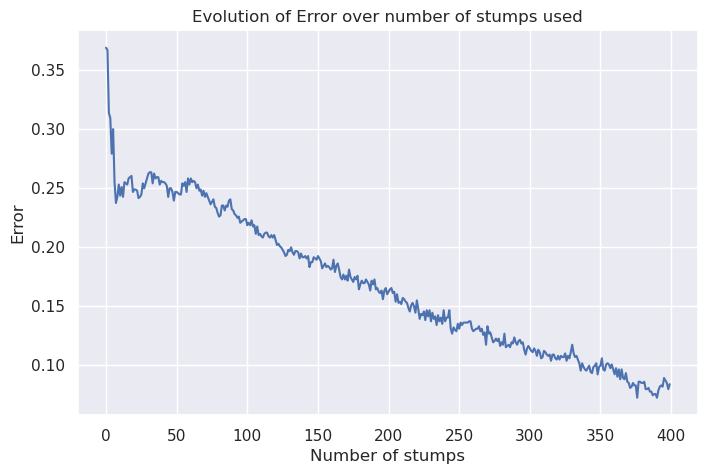

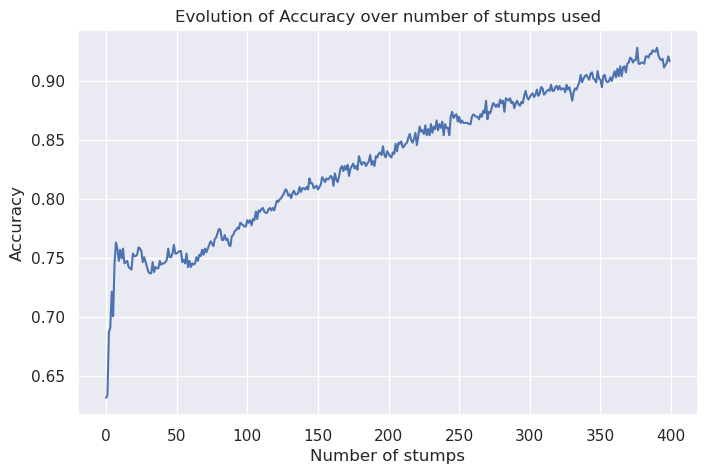

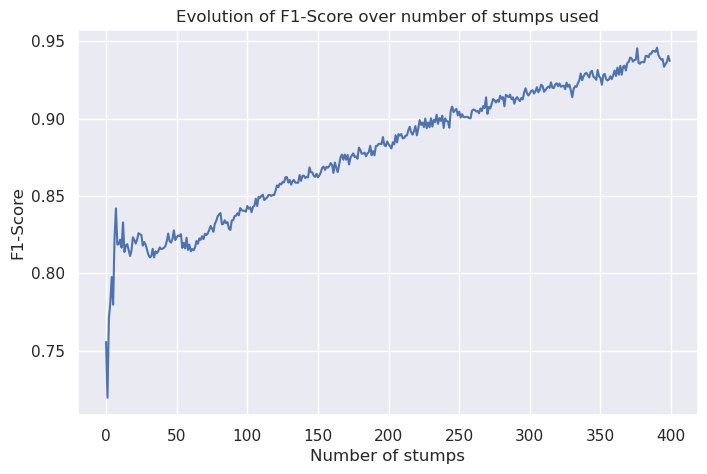

In [227]:
def plot_metric(data: npt.NDArray[np.float64], metric: np.string_, save: bool = False) -> None:
    sns.set(style="darkgrid", color_codes=True, rc={"figure.figsize": (8, 5)})
    sns.lineplot(data=data)
    plt.title(f"Evolution of {metric} over number of stumps used")
    plt.xlabel("Number of stumps")
    plt.ylabel(f"{metric}")
    if save:
        plt.savefig(f"../report/images/{metric}")
    plt.show()

plot_metric(data=errors, metric="Error", save=True)
plot_metric(data=accuracy_scores, metric="Accuracy", save=True)
plot_metric(data=f1_scores, metric="F1-Score", save=True)